## Imports

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from keras.models import Model
import os
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import sklearn
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

## Classes to handle dataset images

In [11]:
class DatasetHandler:
    def __init__(self,
                 model_path,
                 dataset,
                 img_width=200,
                 img_height=200,
                 batch_size=32):
        
        self.model_path = model_path
        self.dataset = dataset
        self.img_width = img_width
        self.img_height = img_height
        self.obstacle_images = []
        self.no_obstacle_images = []
        self.sdv_images = []
        self._update_image_lists = False
        self.batch_size = batch_size
            
        # Will be determined while reading all images from dataset
        self.num_obstacles = 0
        self.num_no_obstacles = 0
        self.num_sdvs = 0
        self.num_images = 0
            
        (self.obstacle_image_names,
        self.num_obstacles) = self._get_all_dataset_image_names(self.dataset, 'obstacle')
        (self.no_obstacle_image_names,
        self.num_no_obstacles) = self._get_all_dataset_image_names(self.dataset, 'no_obstacle')
        (self.sdv_image_names,
        self.num_sdvs) = self._get_all_dataset_image_names(self.dataset, 'sdv')
                            
    def _get_all_dataset_image_names(self, dataset, class_name):
        class_dataset = os.path.join(dataset, class_name)
        image_names = os.listdir(class_dataset)
        image_paths = [os.path.join(class_dataset, image_name) for image_name in image_names]
        
        return image_paths, len(image_paths)
            
    def _get_image(self, imname):
        imrgb = cv2.imread(imname)
        im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2GRAY) 
        
        return im
    
    def get_metrics(self, model, color_mode='rgb'):
        datagen = ImageDataGenerator(rescale=1./255)

        val_generator = datagen.flow_from_directory(
            self.dataset,
            target_size=(self.img_width, self.img_height),
            color_mode=color_mode,
            batch_size=self.batch_size,
            shuffle=False,
            class_mode='categorical'
        )

        return model.evaluate_generator(val_generator, verbose=1)
        
    def get_predictions(self, model, color_mode='rgb'):
        datagen = ImageDataGenerator(rescale=1./255)

        val_generator = datagen.flow_from_directory(
            self.dataset,
            target_size=(self.img_width, self.img_height),
            color_mode=color_mode,
            batch_size=self.batch_size,
            shuffle=False,
            class_mode='categorical'
        )

        ret = model.predict_generator(val_generator, verbose=1)
        filenames = val_generator.filenames

        return ret, filenames
        
    def print_model_metrics(self, model, color_mode):
        metrics = self.get_metrics(model, color_mode)

        for name, value in zip(model.metrics_names, metrics):
            print(name, ': ', value)
            
    # Compute and plot multi-class confusion-matrix
    def plot_cm(self, model_path, labels, predictions):
        cm = confusion_matrix(labels, predictions) 
        print(f'cm: {cm}')
        
        # Creating a dataframe for a array-formatted Confusion matrix
        cm_df = pd.DataFrame(cm,
                             index = ['NO_OBSTACLE','OBSTACLE','SDV'], 
                             columns = ['NO_OBSTACLE','OBSTACLE','SDV'])
        
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.title('Confusion matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
    # Compute and plot multi-class confusion-matrix, with given threshold values
    def plot_cm_with_thresh(self, model_path, labels, predictions, predicted_classes, thresh):
        
        # Calculate number of values for each <class vs. class> considering the thresholds
        
        noobs_as_noobs = len([i for i, p in enumerate(predicted_classes[:1000])\
                          if p==0\
                          and predictions[i][0] > thresh])
        
        noobs_as_obs = len([i for i, p in enumerate(predicted_classes[:1000])\
                          if p==1\
                          and predictions[i][1] > thresh])
        
        noobs_as_sdv = len([i for i, p in enumerate(predicted_classes[:1000])\
                          if p==2\
                          and predictions[i][2] > thresh])
        
        obs_as_noobs = len([i+1000 for i, p in enumerate(predicted_classes[1000:2000])\
                          if p==0\
                          and predictions[i+1000][0] > thresh])
        
        obs_as_obs = len([i+1000 for i, p in enumerate(predicted_classes[1000:2000])\
                          if p==1\
                          and predictions[i+1000][1] > thresh])
        
        obs_as_sdv = len([i+1000 for i, p in enumerate(predicted_classes[1000:2000])\
                          if p==2\
                          and predictions[i+1000][2] > thresh])
        
        sdv_as_noobs = len([i+2000 for i, p in enumerate(predicted_classes[2000:])\
                          if p==0\
                          and predictions[i+2000][0] > thresh])
        
        sdv_as_obs = len([i+2000 for i, p in enumerate(predicted_classes[2000:])\
                          if p==1\
                          and predictions[i+2000][1] > thresh])
        
        sdv_as_sdv = len([i+2000 for i, p in enumerate(predicted_classes[2000:])\
                          if p==2\
                          and predictions[i+2000][2] > thresh])
        
        noobs_as_undecided = len([i for i, p in enumerate(predicted_classes[:1000])\
                          if p==0\
                          and predictions[i][0] <= thresh])
        
        obs_as_undecided = len([i for i, p in enumerate(predicted_classes[1000:2000])\
                          if p==1\
                          and predictions[i+1000][1] <= thresh])
        
        sdv_as_undecided = len([i for i, p in enumerate(predicted_classes[2000:])\
                          if p==2\
                          and predictions[i+2000][2] <= thresh])
        
        cm = [[noobs_as_noobs, noobs_as_obs, noobs_as_sdv, noobs_as_undecided],
             [obs_as_noobs, obs_as_obs, obs_as_sdv, obs_as_undecided],
             [sdv_as_noobs, sdv_as_obs, sdv_as_sdv, sdv_as_undecided]]
        
        #cm = confusion_matrix(labels, predictions) 
        print(f'cm: {cm}')
        
        # Creating a dataframe for a array-formatted Confusion matrix
        cm_df = pd.DataFrame(cm,
                             index = ['NO_OBSTACLE', 'OBSTACLE', 'SDV'], 
                             columns = ['NO_OBSTACLE', 'OBSTACLE', 'SDV', 'NOT_DECIDED'])
        
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.title('Confusion matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')        

## Custom Loss Function

In [12]:
def custom_loss(y_true, y_pred):
    yt_1_2 = y_true[:, 1:]
    yp_1_2 = y_pred[:, 1:]
    
    return tf.keras.metrics.categorical_crossentropy(y_true, y_pred)\
         + tf.keras.metrics.categorical_crossentropy(yt_1_2, yp_1_2)

## Main

Found 3000 images belonging to 3 classes.
94/94 [==============================] - 15s 151ms/step - loss: 0.7434 - auc: 0.9967 - recall: 0.9610 - specifity: 0.9952 - categorical_accuracy: 0.9653
loss :  0.7434319853782654
auc :  0.9966984987258911
recall :  0.9610000252723694
specifity :  0.9951666593551636
categorical_accuracy :  0.9653333425521851
Found 3000 images belonging to 3 classes.
94/94 [==============================] - 17s 180ms/step
cm: [[949, 16, 5, 18], [4, 932, 17, 26], [0, 13, 957, 14]]


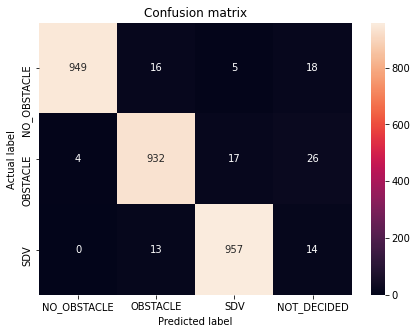

In [13]:
# -- Variables --
trial_component_display_name = '3-class-2021-09-18-22-05-00-training-trial'
model_path = '/home/drevital/cs_video_processor/models/new_factory_3_class_custom'
dataset = '/home/drevital/obstacles_classification_datasets/3_class/eval'
model_name = model_path.split('/')[-1]
color_mode = 'rgb'

# -- Run the Evaluation --
model = tf.keras.models.load_model(model_path, custom_objects={'custom_loss': custom_loss})
#model = tf.keras.models.load_model(model_path)
handler = DatasetHandler(model_path, dataset)

# -- Print metrics
metrics = handler.print_model_metrics(model, color_mode)
labels = np.array([0]*handler.num_no_obstacles\
                + [1]*handler.num_obstacles\
                + [2]*handler.num_sdvs)

# -- Predict with the model
predictions, filenames = handler.get_predictions(model, color_mode=color_mode)

# -- Convert predictions to one-hot array
predicted_classes = predictions.argmax(axis=1)

# -- Print confision-matrix considering the older "no decision" thresholds
#handler.plot_cm(model_path, labels, preds)
handler.plot_cm_with_thresh(model_path, labels, predictions, predicted_classes, thresh=0.65)